Подключение гугл диска

In [1]:
from google.colab import drive
drive.mount('/content/drive')
number_of_interations = 1
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Mounted at /content/drive
Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  1


Библиотеки

In [2]:
from pandas import read_csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from tensorflow.keras import layers

Keras SimpleRNN
The function below returns a model that includes a SimpleRNN layer and a Dense layer for learning sequential data. The input_shape specifies the parameter (time_steps x features). We’ll simplify everything and use univariate data, i.e., one feature only; the time_steps are discussed below.

In [142]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = keras.Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation = activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
    return model

demo_model = create_RNN(5, 1, (3,1), activation=['relu', 'softmax'])
demo_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_32 (SimpleRNN)    (None, 5)                 35        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [143]:
wx = demo_model.get_weights()[0]
wh = demo_model.get_weights()[1]
bh = demo_model.get_weights()[2]
wy = demo_model.get_weights()[3]
by = demo_model.get_weights()[4]
 
print('wx = ', wx, ' wh = ', wh, ' bh = ', bh, ' wy =', wy, 'by = ', by)

wx =  [[-0.58911085  0.5074363   0.00714326 -0.37353873 -0.42942834]]  wh =  [[-0.5772613  -0.00974055 -0.5930668  -0.43718582  0.35187334]
 [ 0.30657944 -0.4404249   0.2706206  -0.12699611  0.7890953 ]
 [ 0.39839503 -0.5618062  -0.2828257  -0.49254614 -0.4506252 ]
 [ 0.25744033  0.6180259   0.27200904 -0.69002336  0.04058651]
 [-0.5897324  -0.32916352  0.6488891  -0.2720415  -0.220915  ]]  bh =  [0. 0. 0. 0. 0.]  wy = [[ 0.635906  ]
 [-0.9009354 ]
 [ 0.87726855]
 [-0.36558008]
 [ 0.24382377]] by =  [0.]


In [144]:
x = np.array([1, 2, 3, 4, 5, 6])

# Reshape the input to the required sample_size x time_steps x features 
x_input = np.reshape(x,(1, 6, 1))
y_pred_model = demo_model.predict(x_input)
 
m = 5
h0 = np.zeros(m)
h1 = np.dot(x[0], wx) + h0 + bh
h2 = np.dot(x[1], wx) + np.dot(h1,wh) + bh
h3 = np.dot(x[2], wx) + np.dot(h2,wh) + bh
h4 = np.dot(x[3], wx) + np.dot(h3,wh) + bh
h5 = np.dot(x[4], wx) + np.dot(h4,wh) + bh
h6 = np.dot(x[5], wx) + np.dot(h5,wh) + bh
output = np.dot(h6, wy) + by

#print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3) 
print('h1 = ', h1,'h2 = ', h2,'h3 = ', h3, 'h4 = ', h4, 'h5 = ', h5, 'h6 = ', h6)
 
print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", output)

h1 =  [[-0.58911085  0.50743628  0.00714326 -0.37353873 -0.42942834]] h2 =  [[-0.52265155  0.70360566  0.11871374 -0.18291459 -0.58924591]] h3 =  [[-0.90221222  1.23173249  0.05612228 -0.75343285 -0.84772626]] h4 =  [[-1.12968084  1.27791721  0.12608364 -0.5332856  -0.93181735]] h5 =  [[-1.43918528  1.89165995  0.2661589  -0.97673323 -1.40885605]] h6 =  [[-1.43850112  1.93606985  0.15316654 -0.92613393 -1.43862368]]
Prediction from network  [[1.]]
Prediction from our computation  [[-2.5368517]]


In [145]:
# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

dataset_url = 'https://raw.githubusercontent.com/AnLiMan/RNN/main/TestDataset3.csv' 
train_data, test_data, data = get_train_test(dataset_url)

In [146]:
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = 6
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [152]:
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, shuffle = True)
model.summary()

# Сохраним всю модель в  HDF5 файл
model.save("/content/drive/My Drive/Files for colab/RNN_Model" + str(number_of_interations) + ".h5")

Epoch 1/20
66/66 - 1s - loss: 0.2021 - accuracy: 0.0152
Epoch 2/20
66/66 - 0s - loss: 0.1822 - accuracy: 0.0152
Epoch 3/20
66/66 - 0s - loss: 0.1690 - accuracy: 0.0152
Epoch 4/20
66/66 - 0s - loss: 0.1580 - accuracy: 0.0152
Epoch 5/20
66/66 - 0s - loss: 0.1485 - accuracy: 0.0152
Epoch 6/20
66/66 - 0s - loss: 0.1399 - accuracy: 0.0152
Epoch 7/20
66/66 - 0s - loss: 0.1318 - accuracy: 0.0152
Epoch 8/20
66/66 - 0s - loss: 0.1239 - accuracy: 0.0152
Epoch 9/20
66/66 - 0s - loss: 0.1151 - accuracy: 0.0152
Epoch 10/20
66/66 - 0s - loss: 0.1051 - accuracy: 0.0152
Epoch 11/20
66/66 - 0s - loss: 0.0921 - accuracy: 0.0303
Epoch 12/20
66/66 - 0s - loss: 0.0736 - accuracy: 0.0303
Epoch 13/20
66/66 - 0s - loss: 0.0524 - accuracy: 0.0303
Epoch 14/20
66/66 - 0s - loss: 0.0341 - accuracy: 0.0303
Epoch 15/20
66/66 - 0s - loss: 0.0219 - accuracy: 0.0303
Epoch 16/20
66/66 - 0s - loss: 0.0152 - accuracy: 0.0303
Epoch 17/20
66/66 - 0s - loss: 0.0117 - accuracy: 0.0303
Epoch 18/20
66/66 - 0s - loss: 0.0095 - 

In [148]:
# Восстановим в точности ту же модель, включая веса и оптимизатор

Loading_model = keras.models.load_model("/content/drive/My Drive/Files for colab/RNN_Model" + str(number_of_interations) + ".h5")
Loading_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_33 (SimpleRNN)    (None, 3)                 15        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 4         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [154]:
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.084 RMSE
Test RMSE: 0.082 RMSE


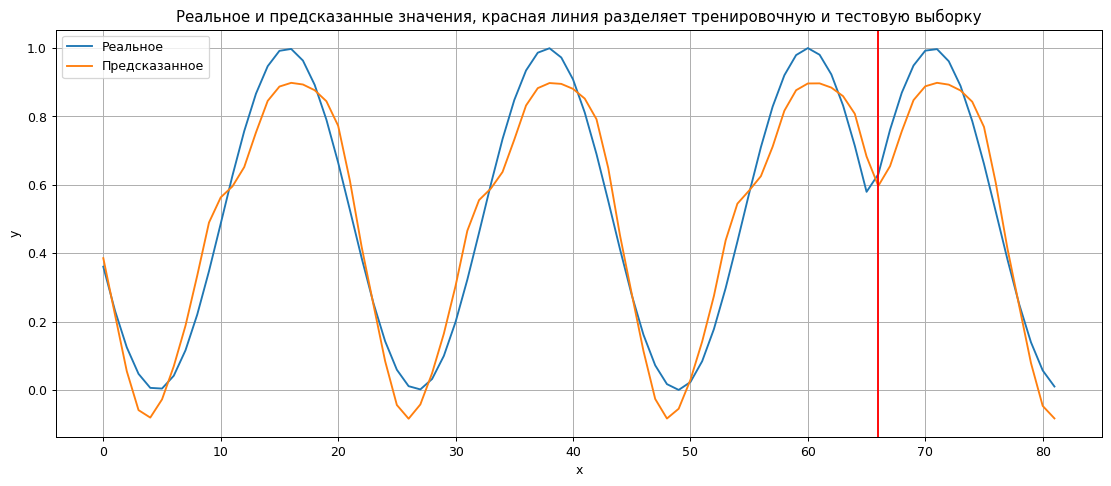

In [155]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()
plot_result(trainY, testY, train_predict, test_predict)